In [23]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [24]:
# import sklearn
# sklearn.__version__
# # '1.0.2'

In [25]:
# Custom rc definitions
rc = {
        'axes.spines.right': True,
        'axes.spines.top': True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        # 'Arial',
        'DejaVu Sans',
        # 'Liberation Sans',
        # 'Bitstream Vera Sans',
        # 'sans-serif',
        "xtick.bottom":True,
        'axes.edgecolor': 'indigo',
        'xtick.color': 'black',
        'figure.facecolor': "snow",
        'grid.color': 'grey',
        
}


# font definitions
font_label = {'family': 'serif',
        'color':  'darkred',
        'weight': 'semibold',
        'size': 16,
        }

font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 16,
        }

font_fig = {'family': 'sans',
        'color':  'chocolate',
        # 'weight': 'bold', # doesn't apply to it. Must be specified independently
        # 'fontsize': 30, # doesn't apply to it. Must be specified independently
        }

In [26]:
data = pd.read_csv("../my_data/clusters.csv")

In [27]:
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,class,clusters
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,jasmine,3
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,jasmine,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,jasmine,3
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,jasmine,3
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,jasmine,3


In [28]:
data = pd.get_dummies(data,columns=['class'],drop_first=True)
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,clusters,class_jasmine
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,3,1
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,1,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,3,1
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,3,1
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,3,1


In [29]:
from sklearn.model_selection import  GridSearchCV,ShuffleSplit,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [30]:
X = data.drop(columns=["class_jasmine"])
y = data.class_jasmine

In [31]:
to_transform = ['area','majoraxislength','minoraxislength',
                'convexarea','equivdiameter','perimeter']

indexes = [ X.columns.tolist().index(value) for value in to_transform]
indexes

[0, 1, 2, 4, 5, 7]

In [32]:
# Scaler
scaler = StandardScaler()

# Column transformer
ct1 = ColumnTransformer([
    ('scale',scaler,indexes)],
    remainder='passthrough')

In [33]:
ct1

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 [0, 1, 2, 4, 5, 7])])

In [34]:
my_pipe = Pipeline([
    ("ct",ct1),
    ('pca',PCA(n_components=6)),
    ('clf',KNeighborsClassifier(n_jobs=-2))
])

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.20)

In [36]:
my_params = [
    {
        # KNN
        'clf':[KNeighborsClassifier(n_jobs=-2)],
        'clf__n_neighbors':[3,4,5,6],
        "clf__weights":['uniform','distance'],
        "clf__p":[1,2]
    },

    {
        # RandomForestClassifier
        'clf':[RandomForestClassifier(random_state=42,warm_start=True,n_jobs=-2)],
        "clf__n_estimators":[50,100,150,200],
        "clf__max_depth":[3,5,7],
        'clf__min_samples_split':[2,3,5]
    },

    {
        # SGDClassifier
        "clf":[SGDClassifier(random_state=42,warm_start=True,n_jobs=-2)],
        'clf__early_stopping':[True,False],
        'clf__loss':['hinge','log_loss'],
        "clf__alpha":[0.0001, 0.0005,0.001,0.005,0.01]
    },

    {
        "clf":[GradientBoostingClassifier(random_state=42,warm_start=True)],
        "clf__learning_rate":[0.001,0.01,0.1,1],
        "clf__n_estimators":[10,30,50,70,90,100],
        "clf__min_samples_split":[2,4],
        "clf__max_depth":[2,3,4]
    }
]

my_cv = ShuffleSplit(n_splits=5,test_size=.20,random_state=42)

In [37]:
mygrid = GridSearchCV(my_pipe,param_grid=my_params,cv=my_cv)
mygrid.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 4,
                                                                          5,
                                                                          7])])),
                                       ('pca', PCA(n_components=6)),
                                       ('clf',
                                        KNeighborsClassifier(n_jobs=-2))]),
             param_grid=[{'clf': [KNeighborsClassifier(n_jobs=-2)],
                          'c

In [38]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf': GradientBoostingClassifier(max_depth=2, min_samples_split=4, random_state=42,
                           warm_start=True), 'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__min_samples_split': 4, 'clf__n_estimators': 100}

Best estimator: Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  [0, 1, 2, 4, 5, 7])])),
                ('pca', PCA(n_components=6)),
                ('clf',
                 GradientBoostingClassifier(max_depth=2, min_samples_split=4,
                                            random_state=42,
                                            warm_start=True))])

Best validation score: 0.9912181303116148


In [47]:
print(mygrid.best_estimator_.named_steps['clf'].feature_importances_)
print(len(mygrid.best_estimator_.named_steps['clf'].feature_importances_))

[6.67977347e-01 1.45468836e-01 1.85577800e-01 3.94224465e-04
 1.65376909e-04 4.16416228e-04]
6


In [73]:
pca_components = mygrid.best_estimator_.named_steps['pca'].n_components
pca_component_names = [f"component_{component+1}" 
                        for component in range(pca_components)]
pca_component_names

['component_1',
 'component_2',
 'component_3',
 'component_4',
 'component_5',
 'component_6']

In [101]:
# With a pipeline and grid search
def feature_importance(model):
    importance = model.feature_importances_
    importance_sort_index = np.argsort(importance)[::-1]
    print(f"Feature importance: \n{importance}\n\n")
    print(f"Feature importance sorted index: \n{importance_sort_index}\n\n")
    print(f"Feature importance sorted: \n{importance[importance_sort_index]}\n\n")
    feature_dict = {}
    for index in importance_sort_index:
        feature_dict[pca_component_names[index]] = float(importance[index])
    print(f"The features with their names:\n{feature_dict}")
feature_importance(mygrid.best_estimator_.named_steps['clf'])

Feature importance: 
[6.67977347e-01 1.45468836e-01 1.85577800e-01 3.94224465e-04
 1.65376909e-04 4.16416228e-04]


Feature importance sorted index: 
[0 2 1 5 3 4]


Feature importance sorted: 
[6.67977347e-01 1.85577800e-01 1.45468836e-01 4.16416228e-04
 3.94224465e-04 1.65376909e-04]


The features with their names:
{'component_1': 0.667977346644656, 'component_3': 0.18557780017812847, 'component_2': 0.14546883557544613, 'component_6': 0.00041641622821602384, 'component_4': 0.00039422446457014205, 'component_5': 0.00016537690898326063}


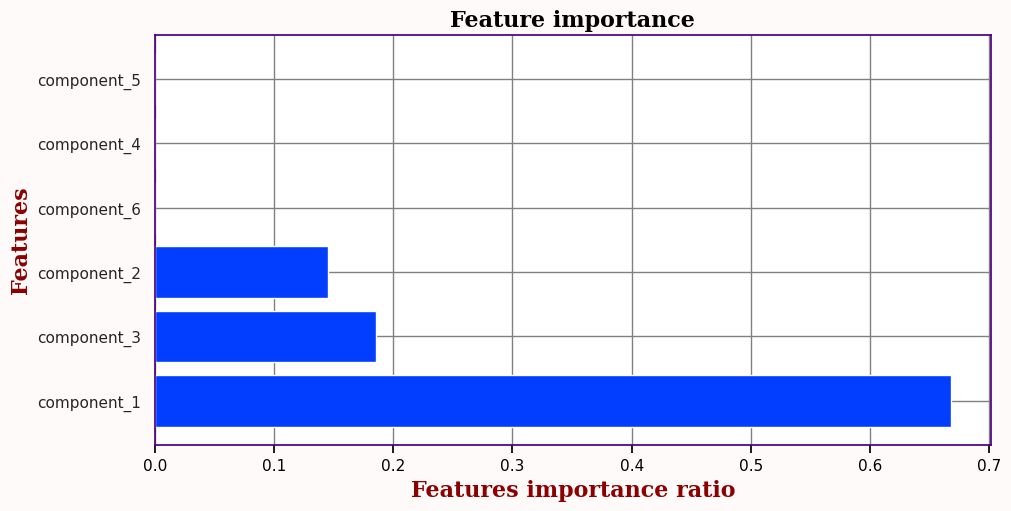

In [100]:
def plot_feature_importances(model):
    fig,ax = plt.subplots(1, figsize=(10,5),constrained_layout=True)
    sns.set_theme(style='whitegrid',rc=rc,palette='bright')
    
    importance = model.feature_importances_
    importance_sort_index = np.argsort(importance)[::-1]
    pca_component_names_sorted = [pca_component_names[component] 
                        for component in importance_sort_index]


    n_features = len(pca_component_names)
    
    plt.barh(range(n_features),
            model.feature_importances_[importance_sort_index],
            align='center')
    plt.yticks(np.arange(n_features), pca_component_names_sorted)
    plt.xlabel('Features importance ratio',fontdict=font_label)
    plt.ylabel('Features',fontdict=font_label)
    plt.title('Feature importance',fontdict=font_title)


plot_feature_importances(mygrid.best_estimator_.named_steps['clf'])

### **Training data**

In [142]:
# from collections import Counter
# print(Counter(y_test.values))
# print(len(X_test))
# # Counter({1: 1931, 0: 1599})
# # 3530

Counter({1: 1931, 0: 1599})
3530


In [112]:
mygrid_trainset = mygrid.best_estimator_

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6485
           1       0.99      0.99      0.99      7632

    accuracy                           0.99     14117
   macro avg       0.99      0.99      0.99     14117
weighted avg       0.99      0.99      0.99     14117



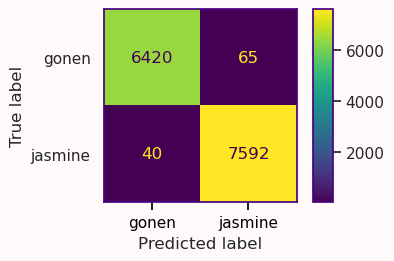

In [134]:
from sklearn.metrics import classification_report,\
    confusion_matrix, ConfusionMatrixDisplay

y_pred_train = mygrid_trainset.predict(X_train)
y_train = y_train

def class_report(model,y_train,y_pred_train):
    fig,ax = plt.subplots(1, figsize=(5,2.5),constrained_layout=True)
    sns.set_theme(style='white',rc=rc,palette='bright')
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=['gonen','jasmine'])
    disp.plot(ax=ax)
    plt.show()

class_report(mygrid_trainset,y_train,y_pred_train)

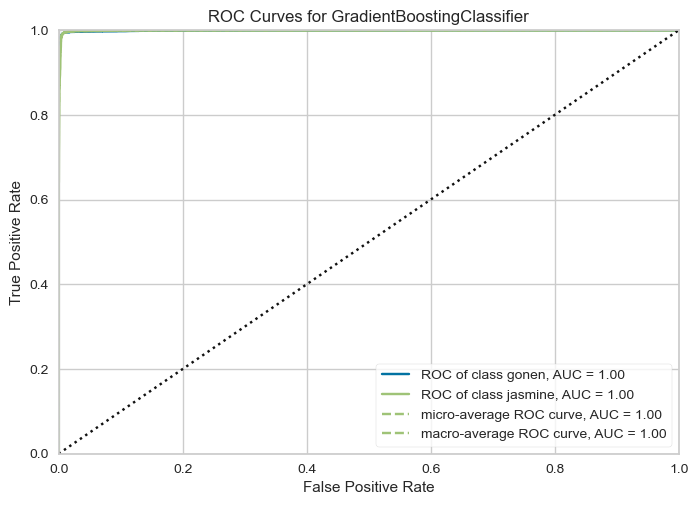

<AxesSubplot:title={'center':'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [136]:
from yellowbrick.classifier import ROCAUC
visualiser = ROCAUC(mygrid_trainset,classes=['gonen','jasmine'])

visualiser.fit(X_train, y_train)        # Fit the training data to the visualizer
visualiser.score(X_train, y_train)        # Evaluate the model on the training data
visualiser.show()

### **Test data**

In [137]:
mygrid_testset = mygrid.best_estimator_

In [152]:
# X_test_transformed = (mygrid.best_estimator_.
#                     named_steps['ct'].transform(X_test))

# X_test_transformed = (mygrid.best_estimator_.
#                     named_steps['pca'].transform(X_test_transformed))

# print(X_test_transformed[:1])
# print(len(X_test_transformed))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1599
           1       0.99      1.00      0.99      1931

    accuracy                           0.99      3530
   macro avg       0.99      0.99      0.99      3530
weighted avg       0.99      0.99      0.99      3530



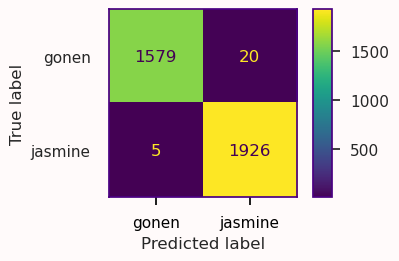

In [155]:
y_pred_test = mygrid_testset.predict(X_test)
y_test = y_test

def class_report(model,y_test,y_pred_test):
    fig,ax = plt.subplots(1, figsize=(5,2.5),constrained_layout=True)
    sns.set_theme(style='white',rc=rc,palette='bright')
    print(classification_report(y_test,y_pred_test))
    cm = confusion_matrix(y_test,y_pred_test,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=['gonen','jasmine'])
    disp.plot(ax=ax)
    plt.show()

class_report(mygrid_testset,y_test,y_pred_test)

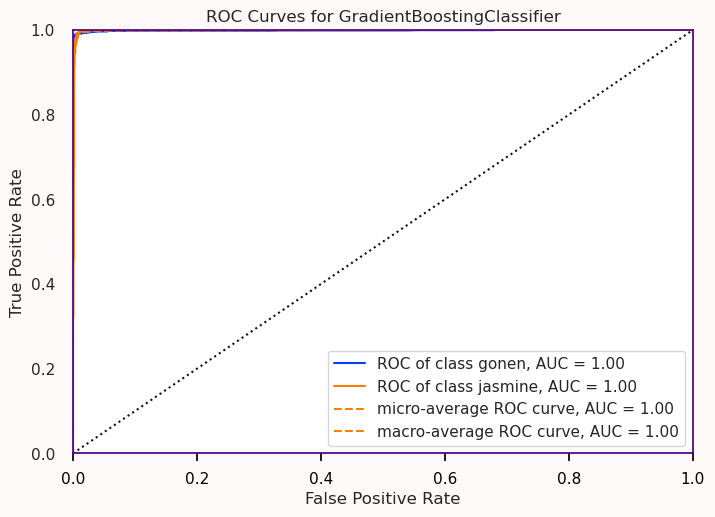

<AxesSubplot:title={'center':'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [156]:
from yellowbrick.classifier import ROCAUC
visualiser = ROCAUC(mygrid_testset,classes=['gonen','jasmine'])

visualiser.fit(X_test, y_test)        # Fit the test data to the visualizer
visualiser.score(X_test, y_test)         # Evaluate the model on the test data
visualiser.show()

In [170]:
import random

def generate_new_data():
    new_data_points = []
    
    for _ in range(5):
        new_data_point = []
        
        # Generate random values for the features
        new_data_point.append(random.randint(0, 10000)) # area
        new_data_point.append(random.uniform(0, 200))   # majoraxislength
        new_data_point.append(random.uniform(0, 100))   # minoraxislength
        new_data_point.append(random.uniform(0, 1))     # eccentricity    
        new_data_point.append(random.randint(0, 10000)) # convexarea
        new_data_point.append(random.uniform(0, 200))   # equivdiameter
        new_data_point.append(random.uniform(0, 1))     # extent
        new_data_point.append(random.uniform(0, 500))   # perimeter
        new_data_point.append(random.uniform(0, 1))     # roundness
        new_data_point.append(random.uniform(0, 5))     # aspectration
        new_data_point.append(random.randint(0, 4))     # clusters

        
        new_data_points.append(new_data_point)
    
    return new_data_points

# Generate 5 new data points
new_data = generate_new_data()
# The list
print(len(new_data),"\n")
print(new_data,"\n")

# The inner list
print(new_data[0],"\n")
print(len(new_data[0]),"\n")

5 

[[8993, 35.006956670566325, 20.213982605595294, 0.5998752865855278, 4258, 11.425196896307877, 0.4788248887912544, 43.191889601324476, 0.4227012981901126, 1.5900095833991439, 4], [3507, 90.70381394409388, 52.45788434335259, 0.953930144961628, 862, 73.85497316759233, 0.28918361835976447, 499.1508604398808, 0.3707672313917174, 3.405268354516426, 3], [3845, 84.5671353491658, 96.97183761991491, 0.7336001478450289, 447, 137.19661784349063, 0.6385222216275336, 327.2594712718587, 0.21195615741628426, 3.067534732298858, 0], [6577, 154.96432116110824, 22.54738356450495, 0.8807190467121832, 1563, 117.05426244438715, 0.0295814205172521, 213.4261646931272, 0.7870344999173498, 4.389517286807091, 3], [4337, 36.71761530334594, 47.71853560254332, 0.26693774115364444, 5065, 25.80191820989235, 0.6910470389873671, 124.62997793644465, 0.45270926921724797, 2.111714707947681, 1]] 

[8993, 35.006956670566325, 20.213982605595294, 0.5998752865855278, 4258, 11.425196896307877, 0.4788248887912544, 43.19188960

In [184]:
mygrid_testset.predict(new_data)

array([0, 1, 0, 1, 0], dtype=uint8)

In [185]:
mapper = {0:"gonen",1:"jasmine"}
predictions = list(mygrid_testset.predict(new_data))
mapped_predictions = [mapper[value] for value in predictions]
mapped_predictions

['gonen', 'jasmine', 'gonen', 'jasmine', 'gonen']

In [188]:
import pickle

with open('../model/pipeline_classifier.pkl','wb') as filer:
    pickle.dump(mygrid.best_estimator_,filer)